
This notebook is a test notebook to create a TCGAN model minverva-like for the purpose to insert this model onto the new GANs Module which is being updated. On this notebook is going to be presented the way Dami used the TCGAN Model (That we are calling Dami's model) and how he trained it, and then we are going to create a new TCGAN model outside this notebook, and then we are going to train it the same way we did with the Dami's model, and compare the graphs to see if it is training the same way with all the datasets.



## Important imports

### General Imports

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
from torchsummary import summary

import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
import time
import os
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

### Minerva Imports

In [3]:
from TCGAN_model import TCGAN_Discriminator, TCGAN_Generator, TCGAN_Encoder #Temporary TCGAN local import

from minerva.models.nets.time_series.gans import GAN, TTSGAN_Encoder, TTSGAN_Discriminator, TTSGAN_Generator
from minerva.data.data_module_tools import RandomDataModule
import torch
import lightning as L

/home/vinicius/Documentos/HIAAC/tcgan/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Testing the Nicolas' DataLoader

In [ ]:
from minerva.data.data_modules.har import MultiModalHARSeriesDataModule

data_path='/home/vinicius/Documentos/HIAAC/standardize_view/KuHar'
data_path='/home/vinicius/Documentos/HIAAC/standardize_view/MotionSense'
# Crie uma instância do DataModule
data_module = MultiModalHARSeriesDataModule(
    data_path=data_path,
    batch_size=32,
    num_workers=4
)

# Configure o DataModule
data_module.setup(stage='fit')

# Acesse o train_dataloader
train_loader = data_module.train_dataloader()
# Exemplo de iteração através do train_loader para ver o shape dos dados
b = 0
for batch in train_loader:
    b+=1
    X_batch, y_batch = batch
    print(f"Shape of X_batch: {X_batch.shape}")
    print(f"Shape of y_batch: {y_batch.shape}")
    break  # Apenas para ver o shape do primeiro batch

Using DataLoader with shuffle=True
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])
Shape of y_batch: torch.Size([32])
Shape of X_batch: torch.Size([32, 6, 60])

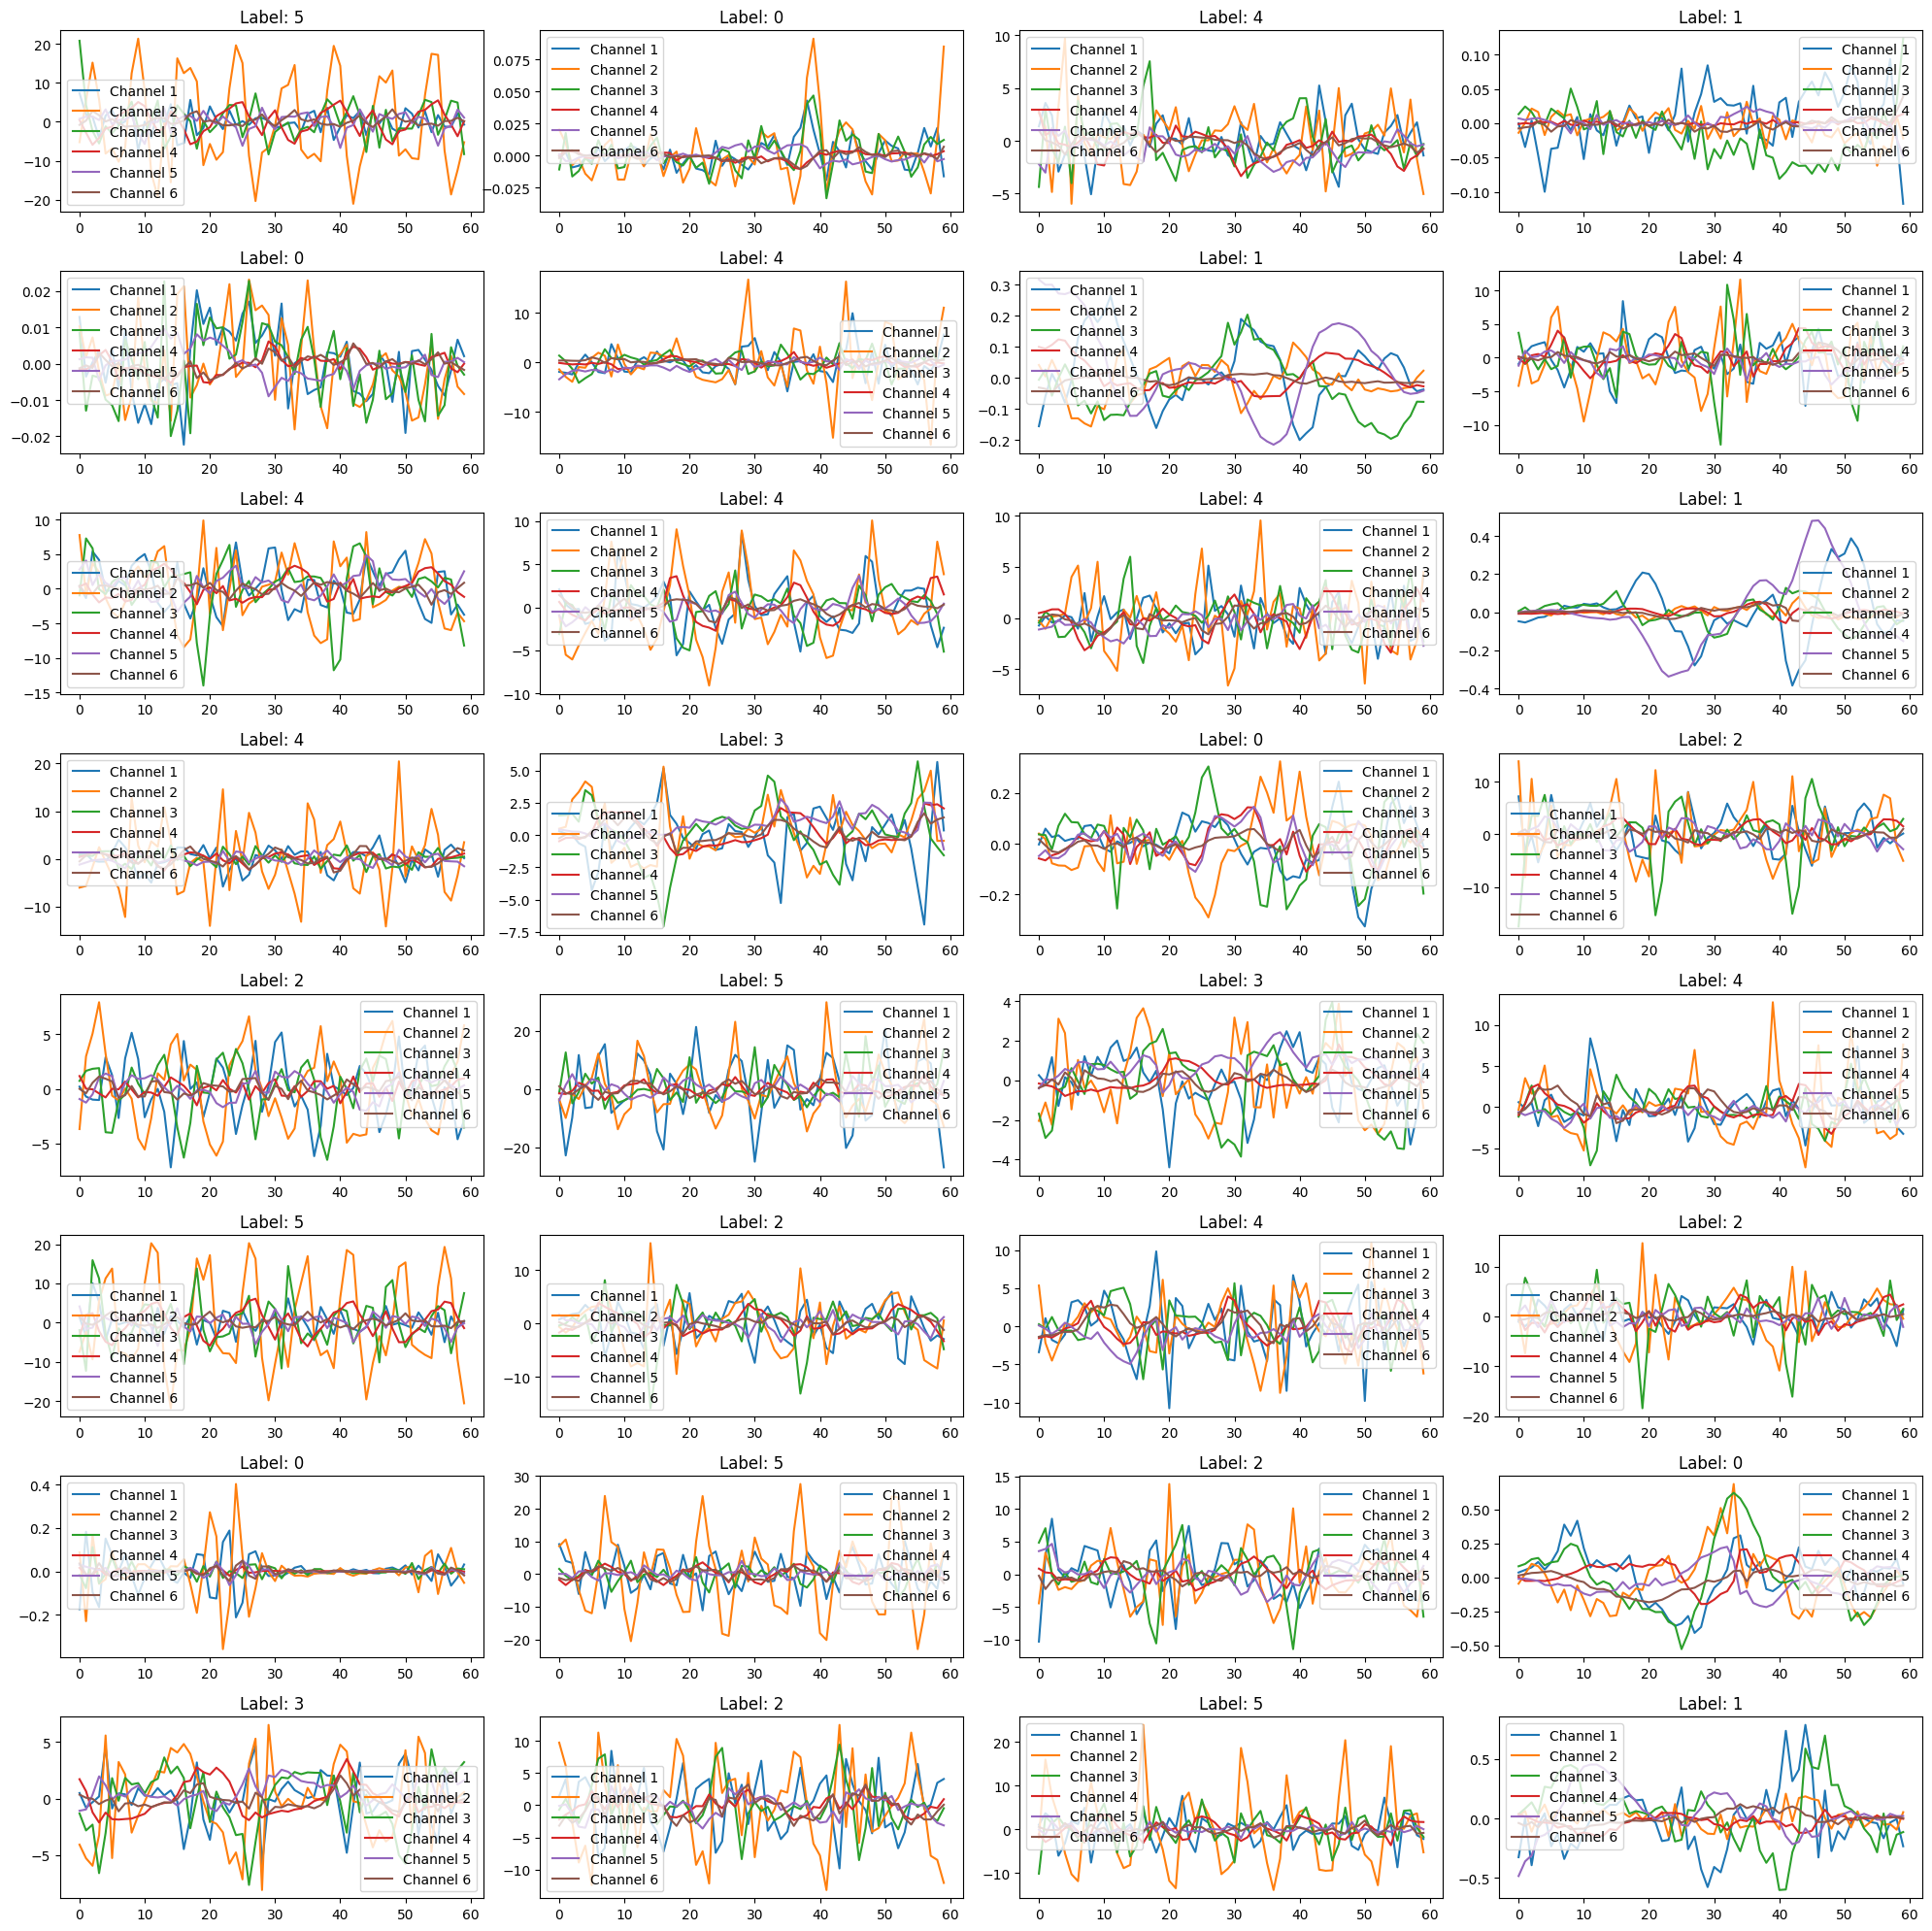

In [ ]:
import matplotlib.pyplot as plt

def plot_batch(X_batch, y_batch):
    """
    Plota todos os b elementos do batch e escreve o título de cada subplot com o valor de y_batch[i].

    Parameters
    ----------
    X_batch : torch.Tensor
        O tensor contendo os dados do batch com shape (b, C, T).
    y_batch : torch.Tensor
        O tensor contendo os rótulos do batch com shape (b,).
    """
    num_samples = X_batch.shape[0]
    num_channels = X_batch.shape[1]
    time_steps = X_batch.shape[2]

    fig, axes = plt.subplots(num_samples // 4, 4, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(num_samples):
        for j in range(num_channels):
            axes[i].plot(X_batch[i, j].cpu().numpy(), label=f'Channel {j+1}')
        axes[i].set_title(f'Label: {y_batch[i].item()}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Exemplo de uso
# Supondo que você tenha um batch de dados
for batch in train_loader:
    X_batch, y_batch = batch
    plot_batch(X_batch, y_batch)
    break  # Apenas para plotar o primeiro batch

## Function that makes videos from images

In [33]:
from PIL import Image
import os
import re

def numerical_sort(value):
    """
    Custom sort function to sort filenames with numerical values correctly.
    """
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else 0

def create_gif(image_paths, output_gif_path, duration=500):
    images = [Image.open(image_path) for image_path in image_paths]
    # Save as GIF
    images[0].save(
        output_gif_path,
        save_all=True,
        append_images=images[1:],
        duration=duration,
        loop=0  # 0 means infinite loop
    )

# Example usage
image_folder = 'Images/TSNE'
root = '/home/vinicius/Documentos/HIAAC/tcgan/Minerva_experiments/'
output_gif_path = "Images/animation.gif"

# Get all PNG files in the folder and sort them numerically
image_files = sorted(os.listdir(image_folder), key=numerical_sort)
image_paths = [os.path.join(image_folder, file_name) for file_name in image_files if file_name.endswith('.png')]

create_gif(image_paths, output_gif_path, duration=200)

print(f"GIF created and saved at {output_gif_path}")

GIF created and saved at Images/animation.gif


In [6]:
import imageio
import os
import re

def numerical_sort(value):
    """
    Custom sort function to sort filenames with numerical values correctly.
    """
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else 0

def create_gif(image_folder, gif_path, duration=0.5):
    """
    Create a GIF from a series of PNG images.

    Parameters
    ----------
    image_folder : str
        Path to the folder containing the PNG images.
    gif_path : str
        Path to save the generated GIF.
    duration : float, optional
        Duration for each frame in the GIF, by default 0.5 seconds.
    """
    # Get all PNG files in the folder
    images = []
    for file_name in sorted(os.listdir(image_folder), key=numerical_sort):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))

    # Create and save the GIF
    imageio.mimsave(gif_path, images, duration=duration)

# Example usage
image_folder = '/home/vinicius/Documentos/HIAAC/tcgan/Minerva_experiments/Images/TSNE/Original'
gif_path = '/home/vinicius/Documentos/HIAAC/tcgan/Minerva_experiments/Images/TSNE/Original/animation.gif'
create_gif(image_folder, gif_path, duration=200)

/tmp/ipykernel_9175/2202972158.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


## Teste de uso do modelo tcgan

In [ ]:
import torch.nn.functional as F
from torch import nn
import torch

l_relu = nn.LeakyReLU(0.2)
input = torch.randn(2)
func = F.leaky_relu(input, negative_slope=0.2)
n = l_relu(input)

func, n

(tensor([-0.1072, -0.0676]), tensor([-0.1072, -0.0676]))

In [4]:
from TCGAN_model import TCGAN_Discriminator

discriminator = TCGAN_Discriminator()
print(discriminator.state_dict().keys())
a = discriminator.backbone # backbone() 
print(a.state_dict().keys())
discriminator.state_dict()['l1.bias']


odict_keys(['l1.weight', 'l1.bias', 'l2.weight', 'l2.bias', 'l3.weight', 'l3.bias', 'l4.module.weight', 'l4.module.bias', 'l4.module.running_mean', 'l4.module.running_var', 'l4.module.num_batches_tracked', 'l5.weight', 'l5.bias', 'l6.module.weight', 'l6.module.bias', 'l6.module.running_mean', 'l6.module.running_var', 'l6.module.num_batches_tracked', 'l7.weight', 'l7.bias', 'backbone.0.weight', 'backbone.0.bias', 'backbone.2.weight', 'backbone.2.bias', 'backbone.4.weight', 'backbone.4.bias', 'backbone.5.module.weight', 'backbone.5.module.bias', 'backbone.5.module.running_mean', 'backbone.5.module.running_var', 'backbone.5.module.num_batches_tracked', 'backbone.7.weight', 'backbone.7.bias', 'backbone.8.module.weight', 'backbone.8.module.bias', 'backbone.8.module.running_mean', 'backbone.8.module.running_var', 'backbone.8.module.num_batches_tracked'])
odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '5.module.weight', '5.module.bias', '5.module.running_mean', 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
#Define two discriminators
d1 = TCGAN_Discriminator()
d2 = TCGAN_Discriminator()

#print the first ever weight
print(f'a: {d1.state_dict()["l1.weight"][0][0][0]}')
print(f'b: {d2.state_dict()["l1.weight"][0][0][0]}')

#print the first ever backbone weight
print(f'backbone of b: {d2.backbone.state_dict()["0.weight"][0][0][0]}')

#change the d1 first ever weight 
d1.state_dict()["l1.weight"][0][0][0] = 100

#load the d1 state_dict to the d2
d2.load_state_dict(d1.state_dict())

#see if backbone changed
print(f"(b <-- a) = c: {d2.state_dict()['l1.weight'][0][0][0]}")
print(f"backbone of c: {d2.backbone.state_dict()['0.weight'][0][0][0]}")

a: 0.019782552495598793
b: -0.012080002576112747
backbone of b: -0.012080002576112747
(b <-- a) = c: 100.0
backbone of c: 100.0


it doest so we can do it as a self.backbone property